<a href="https://colab.research.google.com/github/mehmetgul/ksu-machine-learning/blob/main/kNN_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variable	Description

*   ID number ->	Number of paient
*   Diagnosis ->	(M = malignant, B = benign)
*   radius ->	(mean of distances from center to points on the perimeter)
*   texture ->	(standard deviation of gray-scale values
*   perimeter ->
*   area ->
*   smoothness ->	(local variation in radius lengths)
*   compactness ->	(perimeter^2 / area - 1.0
*   concavity ->	(severity of concave portions of the contour)
*   concave points ->	(number of concave portions of the contour)
*   fractal dimension ->	(coastline approximation - 1)
*   Still There Are other Features

First few rows of the dataset:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimete

interactive(children=(IntSlider(value=3, description='k', max=15, min=1, step=2), Output()), _dom_classes=('wi…

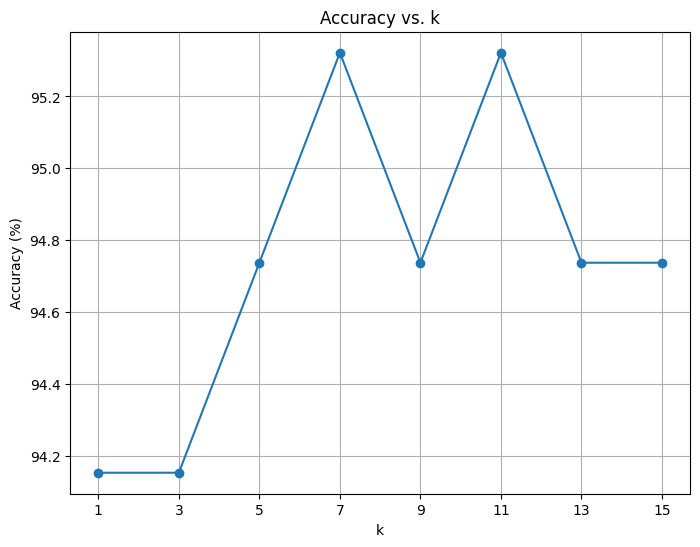

Accuracy for k = 1: 94.15%
Accuracy for k = 3: 94.15%
Accuracy for k = 5: 94.74%
Accuracy for k = 7: 95.32%
Accuracy for k = 9: 94.74%
Accuracy for k = 11: 95.32%
Accuracy for k = 13: 94.74%
Accuracy for k = 15: 94.74%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings('ignore')

# 1. Load and Preprocess the Dataset
# Replace 'bcwdisc.data.mb.csv' with your actual file name
data = pd.read_csv('bcwdisc.data.mb.csv')

# Check the first few rows to understand the data structure
print("First few rows of the dataset:")
print(data.head())

# Drop the 'id' column if it exists
if 'id' in data.columns:
    data = data.drop('id', axis=1)
elif data.columns[0] == 0:
    # If the first column is 'id' but unnamed
    data = data.drop(data.columns[0], axis=1)

# Drop the 'Unnamed: 32' column if it exists
if 'Unnamed: 32' in data.columns:
    data = data.drop('Unnamed: 32', axis=1)

# Convert 'diagnosis' column to numeric values
# Assuming 'diagnosis' is the first column after 'id'
if 'diagnosis' in data.columns:
    data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': -1})
else:
    # If 'diagnosis' is the first column
    diagnosis_col = data.columns[0]
    data[diagnosis_col] = data[diagnosis_col].map({'M': 1, 'B': -1})

# Separate features and labels
X = data.iloc[:, 1:]  # Features
y = data.iloc[:, 0]   # Labels

# Ensure all feature columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values in X
X = X.dropna()
y = y[X.index]  # Ensure y matches the indices of X

# Normalize the features using Min-Max Scaling
def min_max_scaler(X):
    return (X - X.min()) / (X.max() - X.min())

X_normalized = min_max_scaler(X)

# Split the Dataset
dataset = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

# Split into training and testing sets
train_size = int(0.7 * len(dataset))
train_set = dataset.iloc[:train_size, :]
test_set = dataset.iloc[train_size:, :]

X_train = train_set.iloc[:, :-1].values
y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
y_test = test_set.iloc[:, -1].values

# Distance Calculation Module
def calculate_distances(test_sample, X_train):
    # Calculate Euclidean distances between test_sample and all training samples
    distances = np.sqrt(np.sum((X_train - test_sample) ** 2, axis=1))
    return distances

# Assignment Module
def predict_classification(X_train, y_train, test_sample, k):
    distances = calculate_distances(test_sample, X_train)
    # Get the indices of the k nearest neighbors
    k_indices = distances.argsort()[:k]
    k_neighbor_labels = y_train[k_indices]
    # Majority vote
    values, counts = np.unique(k_neighbor_labels, return_counts=True)
    majority_vote = values[np.argmax(counts)]
    return majority_vote

# Function to run kNN and plot results interactively
def knn_interactive(k):
    predictions = []
    for test_sample in X_test:
        prediction = predict_classification(X_train, y_train, test_sample, k)
        predictions.append(prediction)
    accuracy = np.mean(predictions == y_test)
    cm = confusion_matrix(y_test, predictions)

    # Print accuracy
    print(f'Accuracy for k = {k}: {accuracy * 100:.2f}%')

    # Plotting the confusion matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Benign (-1)', 'Malignant (1)'],
                yticklabels=['Benign (-1)', 'Malignant (1)'])
    plt.title(f'Confusion Matrix for k = {k}\nAccuracy = {accuracy * 100:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Confusion Matrix
def confusion_matrix(y_true, y_pred):
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)
    for i, label1 in enumerate(unique_labels):
        for j, label2 in enumerate(unique_labels):
            cm[i, j] = np.sum((y_true == label1) & (y_pred == label2))
    return cm

# Create an interactive slider for k
interact(knn_interactive, k=IntSlider(min=1, max=15, step=2, value=3));

# Function to plot Accuracy vs k
def plot_accuracy_vs_k():
    k_values = range(1, 16, 2)
    accuracies = []
    for k in k_values:
        predictions = []
        for test_sample in X_test:
            prediction = predict_classification(X_train, y_train, test_sample, k)
            predictions.append(prediction)
        accuracy = np.mean(predictions == y_test)
        accuracies.append(accuracy)

    plt.figure(figsize=(8,6))
    plt.plot(k_values, [a * 100 for a in accuracies], marker='o')
    plt.title('Accuracy vs. k')
    plt.xlabel('k')
    plt.ylabel('Accuracy (%)')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

    # Print accuracies
    for k, acc in zip(k_values, accuracies):
        print(f'Accuracy for k = {k}: {acc * 100:.2f}%')

plot_accuracy_vs_k()